# XGBoost to predict the predicted shift in mRS discharge disability due to use of thrombolysis
#### Using 7 features to train a XGBoost regression model 
(based on notebook 050)

Use the same input features as those used in the disability discharge outcome model, predict the predicted mRS shift due to thrombolysis treatment. Then fit SHAP values to the mRS shift model.

### Plain English summary

Assess the performance of a model trained on the selected 7 features, as informed from the feature selection process. Use the first k-fold split.

7 features:
1. prior_disability
1. stroke_severity
1. stroke_team
1. age
1. onset_to_thrombolysis_time
1. any_afib_diagnosis
1. precise_onset_known

### Model and data
Model: XGBoost classifier.
Feature data: 7 selected features
Target feature: Discharge disability
Data: The first kfold

### Aims
What's the performance of a model using the 7 selected features?

##### Section 1: Accuracy of model (and consistency across k-folds)
Look at accuracy in terms of:
1. Accuracy (i. % correct, ii. % within one correct)
1. Confusion matrix
1. ROCAUC
##### Section 2: Calibration and assessment of accuracy when model has high confidence
##### Section 3: Reliability

### Observations


## Import libraries

In [123]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd

import scipy

from xgboost import XGBRegressor#Classifier
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

import json

from dataclasses import dataclass

import seaborn as sns

from sklearn.metrics import roc_auc_score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error

import pickle
import shap

from os.path import exists

import math

import importlib

from sklearn import metrics
from sklearn.linear_model import LinearRegression
# Import local package
#from utils import waterfall
## Force package to be reloaded
#importlib.reload(waterfall);

# Need for cm subplots?
#from mpl_toolkits.axes_grid1 import make_axes_locatable
#from matplotlib.colors import LogNorm
#from matplotlib.ticker import MultipleLocator

import time


# sklearn for pre-processing
from sklearn.model_selection import StratifiedKFold

Report the time duration to run notebook

In [124]:
start_time = time.time()

Set to use only the first kfold

In [125]:
k = 0

Select the features for the model

In [126]:
selected_features_outcome = ["prior_disability", "stroke_severity", "stroke_team", 
                     "age", "onset_to_thrombolysis_time", "any_afib_diagnosis", 
                     "precise_onset_known"]
target_feature = 'predicted_mrs_shift_due_to_thrombolysis'
n_features = len(selected_features_outcome)
selected_features = selected_features_outcome + [target_feature]

## Set up paths and filenames

Use os.path.join() to create filenames. So define folders without trailing forward slash, and include all characters in file names.

In [127]:
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''
    image_save_path: str = './saved_images'
    data_save_path: str = './saved_data'
    model_save_path: str = './saved_models'
    data_read_path: str = '../data_processing/output/kfold_5fold'
    model_text: str = f'xgb_7_features_1fold_mrs_shift'
    notebook: str = '220'

paths = Paths()

Create output folders if needed

In [128]:
path = paths.image_save_path
if not os.path.exists(path):
    os.makedirs(path)
        
path = paths.model_save_path
if not os.path.exists(path):
    os.makedirs(path)

path = paths.data_save_path
if not os.path.exists(path):
    os.makedirs(path)

## Import data

Data has previously been split into 5 stratified k-fold splits.

Import data

In [129]:
# Read in training set & store
filename = os.path.join(paths.data_read_path, 
                        ('03_train_' + str(k) + '.csv'))
train = pd.read_csv(filename)

filename = os.path.join(paths.data_read_path, 
                        ('03_test_' + str(k) + '.csv'))
test = pd.read_csv(filename)

Take copy of stroke team to use to create a histogram (before this feature is converted into a one hot encoded feature)

In [130]:
train_stroke_team = train["stroke_team"]
test_stroke_team = test["stroke_team"]

Calculate the median scan to needle time for each hosptial

In [131]:
all_data = pd.concat([train, test])

# median scan to treatment for the treated patients (per hosptial)
mask_treatment = all_data["onset_to_thrombolysis_time"] > -100
median_scan_to_needle_time = (
    all_data[mask_treatment].groupby(["stroke_team"])["scan_to_thrombolysis_time"].median())

median_scan_to_needle_time

stroke_team
Addenbrooke's Hospital          20.0
Basildon University Hospital    34.0
Blackpool Victoria Hospital     37.0
Bradford and Airedale SU        47.0
Bronglais Hospital              39.5
                                ... 
Worthing Hospital               38.0
Wycombe General Hospital        29.0
Yeovil District Hospital        37.0
York Hospital                   29.0
Ysbyty Gwynedd                  44.0
Name: scan_to_thrombolysis_time, Length: 118, dtype: float64

In [132]:
# For those patients not recieve treatment in the dataset, use the median scan to treatment of their attended hosptial
train_onset_to_scan_time = train["onset_to_arrival_time"] + train["arrival_to_scan_time"]
test_onset_to_scan_time = test["onset_to_arrival_time"] + test["arrival_to_scan_time"]

Select the features for this model

In [133]:
train = train[selected_features_outcome]
test = test[selected_features_outcome]

### One hot the categorical features

Convert some categorical features to one hot encoded features.

Define a function

In [134]:
def convert_feature_to_one_hot(df, feature_name, prefix):
    """
    df [dataframe]: training or test dataset
    feature_name [str]: feature to convert to ont hot encoding
    prefix [str]: string to use on new feature
    """

    # One hot encode a feature
    df_feature = pd.get_dummies(
        df[feature_name], prefix = prefix)
    df = pd.concat([df, df_feature], axis=1)
    df.drop(feature_name, axis=1, inplace=True)

    return(df)

Set up two lists for the one hot encoding. 

A list of the feature names that are categorical and to be converted using one hot encoding.
A list of the prefixes to use for these features.

In [135]:
features_to_one_hot = ["stroke_team", "weekday"]
list_prefix = ["team", "weekday"]

For each feature in the list, for each train and test dataset, convert to one hot encoded.

In [136]:
for feature, prefix in zip(features_to_one_hot, list_prefix):
    if feature in selected_features:
        train = convert_feature_to_one_hot(train, feature, prefix)
        test = convert_feature_to_one_hot(test, feature, prefix)

Feature names with one hot encoding

In [137]:
features_ohe = list(train)
n_features = len(features_ohe)

In [138]:
print(f"There are {len(selected_features_outcome)} original features "
      f"(before one-hot encoding)")
print(f"There are {n_features} features (after one-hot encoding)")

There are 7 original features (before one-hot encoding)
There are 124 features (after one-hot encoding)


In [139]:
print(f'{train["onset_to_thrombolysis_time"].min()} to {train["onset_to_thrombolysis_time"].max()}')

-100.0 to 720.0


In [140]:
# Model filename
filename = os.path.join(paths.model_save_path, 
                '210_xgb_all_data_multiclass_outcome.p')

# Check if exists
file_exists = exists(filename)

if file_exists:
# Load models
    with open(filename, 'rb') as filehandler:
        model_outcome = pickle.load(filehandler)
    mrs_classes = model_outcome.classes_
else:
    # Print warning
    print("Run notebook 220 that trains the model")

In [141]:
def calculate_population_outcome(y_probs, mrs_classes):
    weighted_mrs = (y_probs * mrs_classes).sum(axis=1)
    return(weighted_mrs)

In [142]:
def calculate_target_feature(data, model_outcome,median_scan_to_needle_time, 
                             onset_to_scan_time, stroke_team):
    # Identify patients not recieve treatment in the dataset
    mask_not_treated = data["onset_to_thrombolysis_time"] == -100

    # Take a deep copy of the onset to thrombolysis time. This will remain unchanged 
    # for those patients that recieve treatment in the dataset
    onset_to_thrombolysis_time_all_treated = data["onset_to_thrombolysis_time"].copy(deep=True)

    # For those patients not recieve treatment in the dataset, use the median scan to treatment of their attended hosptial
    #onset_to_scan_time = data["onset_to_arrival_time"] + data["arrival_to_scan_time"]

    #median_scan_to_needle_time = calc_median_scan_to_needle_time(data)
    onset_to_thrombolysis_time_all_treated[mask_not_treated] = (
        onset_to_scan_time[mask_not_treated] + 
        median_scan_to_needle_time[stroke_team[mask_not_treated]])

    # get mrs if treated
    data["onset_to_thrombolysis_time"] = onset_to_thrombolysis_time_all_treated
    y_probs = model_outcome.predict_proba(data)
    weighted_mrs_if_get_ivt = calculate_population_outcome(y_probs, mrs_classes)

    # get mrs if not treated
    data["onset_to_thrombolysis_time"] = -100
    y_probs = model_outcome.predict_proba(data)
    weighted_mrs_if_not_get_ivt = calculate_population_outcome(y_probs, mrs_classes)

    # Calculate mrs shift
    mrs_shift_due_to_thrombolysis = weighted_mrs_if_get_ivt - weighted_mrs_if_not_get_ivt

    return(mrs_shift_due_to_thrombolysis)

In [143]:
print(f'{train["onset_to_thrombolysis_time"].min()} to {train["onset_to_thrombolysis_time"].max()}')

-100.0 to 720.0


In [144]:
train[target_feature] = calculate_target_feature(train.copy(deep=True), model_outcome, 
                                                 median_scan_to_needle_time, 
                                                 train_onset_to_scan_time, 
                                                 train_stroke_team)
test[target_feature] = calculate_target_feature(test.copy(deep=True), model_outcome, 
                                                median_scan_to_needle_time, 
                                                test_onset_to_scan_time, 
                                                test_stroke_team)

In [145]:
print(f'{train["onset_to_thrombolysis_time"].min()} to {train["onset_to_thrombolysis_time"].max()}')

-100.0 to 720.0


Save datafiles to use in notebook 221

In [146]:
filename = os.path.join(paths.data_read_path, 
                        (paths.notebook + '_train_' + str(k) + '_mrs_shift.csv'))
train.to_csv(filename)

filename = os.path.join(paths.data_read_path, 
                        (paths.notebook + '_test_' + str(k) + '_mrs_shift.csv'))
test.to_csv(filename)

## Train XGBoost model

Train model using the first kfold, on the seven selected features to predict the predicted shift in disability of each patient at discharge due to thrombolysis.

Create function to return X and y data for train and test sets

In [147]:
def get_x_y_data(train, test, target):
    """
    Pass data from the split and return the dataframes with the target in one 
    dataframe (X), and dependent features in another (y)
    
    train (dataframe): dataframe containing training instances 
    test (dataframe): dataframe containing test instances
    target (string): column name of the targert feature (the column to separate from the two dataframes)
    """    

    # Get X and y
    X_train = train.drop(target, axis=1)
    X_test = test.drop(target, axis=1)
    y_train = train[target]
    y_test = test[target]

    return(X_train, X_test, y_train, y_test)

Create function to get xgboost model (print error if does not exist)

In [148]:
def fit_xgboost_model(filename, X, y):
    """
    Given the filename, either load if the model exists (saved as a pickle), 
    else train anew model.

    filename [string]: where xgboost model is saved
    X_train [dataframe]: feature values
    y_train [dataframe]: target feature
    """
    # Check if exists
    file_exists = exists(filename)

    if file_exists:
    # Load models
        with open(filename, 'rb') as filehandler:
            model = pickle.load(filehandler)
    else:
        # Define and Fit model
        model = XGBRegressor(verbosity = 0, seed=42, learning_rate=0.5)
        model.fit(X, y)

        # Save using pickle
        with open(filename, 'wb') as filehandler:
            pickle.dump(model, filehandler)
            
    return(model)

In [149]:
# Get k fold split
(X_train, X_test, y_train, y_test) = get_x_y_data(train,
                                                  test,
                                                  target_feature)

# Model filename
filename = os.path.join(paths.model_save_path, 
                (paths.notebook + '_' + paths.model_text + '.p'))

model = fit_xgboost_model(filename, X_train, y_train)

# Get and store prediction
y_pred = model.predict(X_test)

# Calculate accuracy
# evaluate predictions
mse = mean_squared_error(y_pred, y_test)
print("mean_squared_error: %.2f%%" % (mse))

mean_squared_error: 0.02%


#### Scatter plot

In [150]:
def fit_logstic_regression(x, y):
    # Get r-square of predicted thrombolysis rate.
    slr = LinearRegression()
    slr.fit(x, y)
    y_pred = slr.predict(x)
    r_square = metrics.r2_score(y, y_pred)
    return(slr, r_square)

Text(0, 0.5, 'Predicted weighted mRS shift')

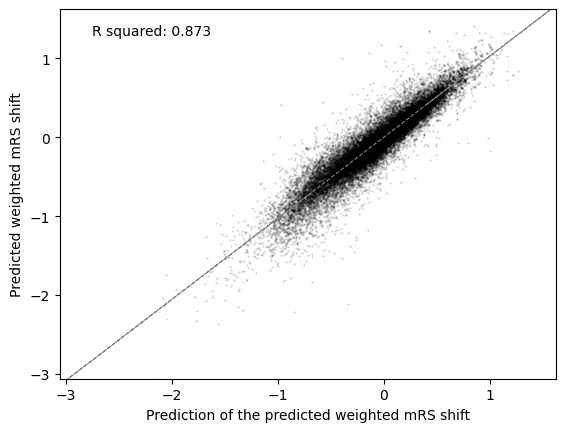

In [151]:
ax = plt.scatter(y_pred, y_test, s=0.8, alpha=0.1, c='k', marker='o')
axis_min = min(np.minimum(y_pred, y_test))
axis_max = max(np.maximum(y_pred, y_test))
# The full dataset
(slr, r_square) = fit_logstic_regression(y_pred.reshape((-1, 1)), y_test)

ax = plt.plot(y_test, slr.predict(np.array(y_test).reshape((-1, 1))), color = 'grey', linewidth=0.8, linestyle="--")
text = f'R squared: {r_square:.3f}'
ax = plt.text(axis_min*0.9, axis_max*0.8, text, 
            bbox=dict(facecolor='white', edgecolor='white'))
ax = plt.xlim(axis_min, axis_max)
ax = plt.ylim(axis_min, axis_max)
#ax = plt.plot([-3,2],[-3,2], c='grey',linewidth=1, linestyle ='--')
plt.xlabel("Prediction of the predicted weighted mRS shift")
plt.ylabel("Predicted weighted mRS shift")

# YOU ARE HERE

## Section 2: Calibration and assessment of accuracy when model has high confidence.

To test for callibration, look at each output classification separately, take all of the instances and group them based on the probability for that classification as given by the model. See how many are that classification. 
For example, all of the instances that the model gives a probability in the range 0.2 to 0.3, in a well callibrated model between 0.2 to 0.3 of these instances would be this category). 

For a multiclass classification model, we calculate the calibration for each class.

Need to get the probability for the true category per instance.

Define function to plot line per kfold data in dataframe

In [ ]:
def plot_fraction_positive(df_reliability, c, ax, n_kfold, 
                           title_text=""):
    """
    df_reliability (dataframe): Contains 3 columns per bin
    c (string): The classification category (used in the plot title)
    ax (matplotlib axis object):  
    """

    # Add 1:1 line
    ax.plot([0,1],[0,1], color='grey', linestyle ='--')

    # Want to view the individual kfolds
    # Loop through k-fold reliability results
    for k in range(n_kfold):
        # Get values for the kfold
        mask = df_reliability['k-fold'] == k
        result_kfold = df_reliability[mask]
        # Plot the confidence vs fraction positive
        x = result_kfold['confidence']
        y = result_kfold['fraction_positive']
        ax.plot(x,y, color='k', alpha=0.6)


    # Refine plot
    ax.set_xlabel('Model probability', fontsize=9)
    ax.set_ylabel('Fraction positive', fontsize=9)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_title(f'Predicting mRS{round(c)}\n{title_text}', fontsize=9)

    return(ax)

In [ ]:
def plot_fraction_positive_average(df_reliability_mean_kfolds, c, ax, 
                                   title_text=""):
    """
    df_reliability (dataframe): Contains 3 columns per bin
    c (string): The classification category (used in the plot title)
    ax (matplotlib axis object):  
    """

    # Add 1:1 line
    ax.plot([0,1],[0,1], color='grey', linestyle ='--')

    # Calculate mean and standard error across the 5 kfolds in new dataframe,
    # for both the x and y
    reliability_overview = pd.DataFrame()

    reliability_overview['confidence_mean'] = \
        df_reliability_mean_kfolds.groupby('bin_nominal').mean()['confidence']

    reliability_overview['confidence_stddev'] = \
        df_reliability_mean_kfolds.groupby('bin_nominal').std()['confidence']

    reliability_overview['confidence_stderr'] = \
        reliability_overview['confidence_stddev']/math.sqrt(5)

    reliability_overview['fraction_positive_mean'] = \
        df_reliability_mean_kfolds.groupby('bin_nominal').mean()['fraction_positive']

    reliability_overview['fraction_positive_stddev'] = \
        df_reliability_mean_kfolds.groupby('bin_nominal').std()['fraction_positive']

    reliability_overview['fraction_positive_stderr'] = \
        reliability_overview['fraction_positive_stddev']/math.sqrt(5)

    x = reliability_overview['confidence_mean']
    y = reliability_overview['fraction_positive_mean']
    xerr = reliability_overview['confidence_stderr']
    yerr = reliability_overview['fraction_positive_stderr']

    ax.errorbar(x, y, yerr=yerr, xerr=xerr, color='k', alpha=0.8)

    # Refine plot
    ax.set_xlabel('Model probability', fontsize=9)
    ax.set_ylabel('Fraction positive', fontsize=9)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_title(f'Predicting mRS{round(c)}\n{title_text}', fontsize=9)

    return(ax)

In [ ]:
def plot_fraction_instances(reliability_collated, ax, n_kfold):
    """
    reliability_collated (dataframe): Contains 3 columns per bin
    c (string): The classification category (used in the plot title)
    ax (matplotlib axis object):  
    """

    # Loop through k-fold reliability results
    for k in range(n_kfold):
        # Get values for the kfold
        mask = reliability_collated['k-fold'] == k
        result_kfold = reliability_collated[mask]
        # Plot the confidence vs fraction positive
        x = result_kfold['confidence']
        y = result_kfold['fraction_results']
        ax.plot(x,y, color='blue')

    # Refine plot
    ax.set_ylabel('Fraction of instances', fontsize=9, color='blue')
    ax.tick_params(axis='y', color='blue')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    return(ax)        


Define function to create the dataframe df_reliability

In [ ]:
def create_df_reliability(digitized, prob_observed,
                          observed_binary, classification, observed, c):
    """
    Put values into a dataframe (contains data for each patient per row. This 
    data is for a certain kfold and the probability for a certain output class.
    A range of bins has already been defined.
    Here record which bin range each patient falls into ('bin'), the probability 
    the model gave ('prob_observed') to be in this class ('c').
    'observed_binary' is whether this patient is a class 'c'
    'observed_class' is the class the patient really is
    'classification' is the class that the patient would be allocated (from teh model - the class with the highest probability)
    'correct_binary' is whether the binary model got it right (T/F about this class)
    'correst_class' is whether the full model got it right (correct class allocated by full model)
    'count' set to 1 for each patient (1 patient)
    'class' this model part is predicting the probability to be this specific class

    
    The values passed in will be for a certain kfold, for a certain class output
    and using a set bin range.
    
    """
    df = pd.DataFrame()
    df['bin'] = digitized
    df['probability_observed'] = prob_observed
    df['observed_binary'] = observed_binary
    df['observed_class'] = observed
#    df['observed'] = observed_binary
    df['classification'] = classification
#    df['correct'] = observed == classification
    df['correct_binary'] = observed_binary == classification
    df['correct_class'] = observed == classification
    df['count'] = 1
    df['class'] = c

    return(df)

Define function to group data in dataframe by value in column "bins"

In [ ]:
def group_data_by_bins(bins, k, df_reliability):
    """
    Create a dataframe that contains the bins ('bin_nominal' is just a label for each range, using a continuous value from 1 to n)
    Store the kfold this is for (this is called for each kfold)
    'confidence' contains the proportion correct within each bin (of the observed cases)
    'fraction positive' proportion of patients in the class (a well calibrated model has the same proportion correct as the bin of the probability)

    """
    df = pd.DataFrame()

    # Add bins and k-fold to summary
    df['bin'] = bins
    df['bin_nominal'] = np.array(range(len(bins)))
    df['k-fold'] = k

    # Calculate mean of predicted probability of correct category in each bin
    df['confidence'] = \
        df_reliability.groupby('bin').mean()['probability_observed']

    # Calculate the proportion of patients in this class
    df[f'fraction_positive'] = \
        df_reliability.groupby('bin').mean()['observed_binary']

    # Calculate proportion correct in each bin
    df['fraction_correct'] = \
        df_reliability.groupby('bin').mean()['correct_class']

    # Calculate fraction of results in each bin
    df['fraction_results'] = \
        df_reliability.groupby('bin').sum()['count'] / df_reliability.shape[0]

    return(df)

Define function to define the bins (based on bin method) and digitize the data (prob_observed) into these bins.

In [ ]:
def calculate_bins_digitized(bin_method, values):
    """
    Depending on the bin method, calculate the bin ranges for the values passed
    in series
    
    bin_method [string]: either 'steps' (bin ranges have equal steps), or 
                         'counts' or 'average' (bin ranges have equal counts)
    values [series]: the values to be binned

    return the bin ranges (bins) and the bins each value sits in (digitized).
    """
    if bin_method == 'steps':
        # Bin data with numpy digitize (this will assign a bin to each instance 
        # based on the probability assigned by the model)
        # Create bins with equal steps
        step = 0.10
        # Using np.round() and tolist() to force the values to be floats
        # with 1dp
        bins = np.round(np.arange(step, 1+step, step),1).tolist()
        digitized = np.digitize(values, bins)
    elif 'counts' in bin_method:
        # Create bins with equal counts (ensure a good number of instances in 
        # each bin)
        (res, bins) = pd.qcut(values, q=10, retbins=True)
        digitized = np.digitize(values, bins)
    return(bins, digitized)

Plot calibration per classification (showing the 5 individual k-folds)

Show the same dta in three ways:
1. binning the data using equal steps (show line per kfold)
1. binning the data using equal counts (show line per kfold)
1. binning the data using equal counts (show average kfold, and standard deviation) [the mean, and standard deviation, across the kfolds: from notebook 01_xgb_5fold_all_features_accuracy_importance_shap.ipynb]. Warning - each kfold has different bin ranges, and so what is shown is the mean bin range too (with standard deviation)

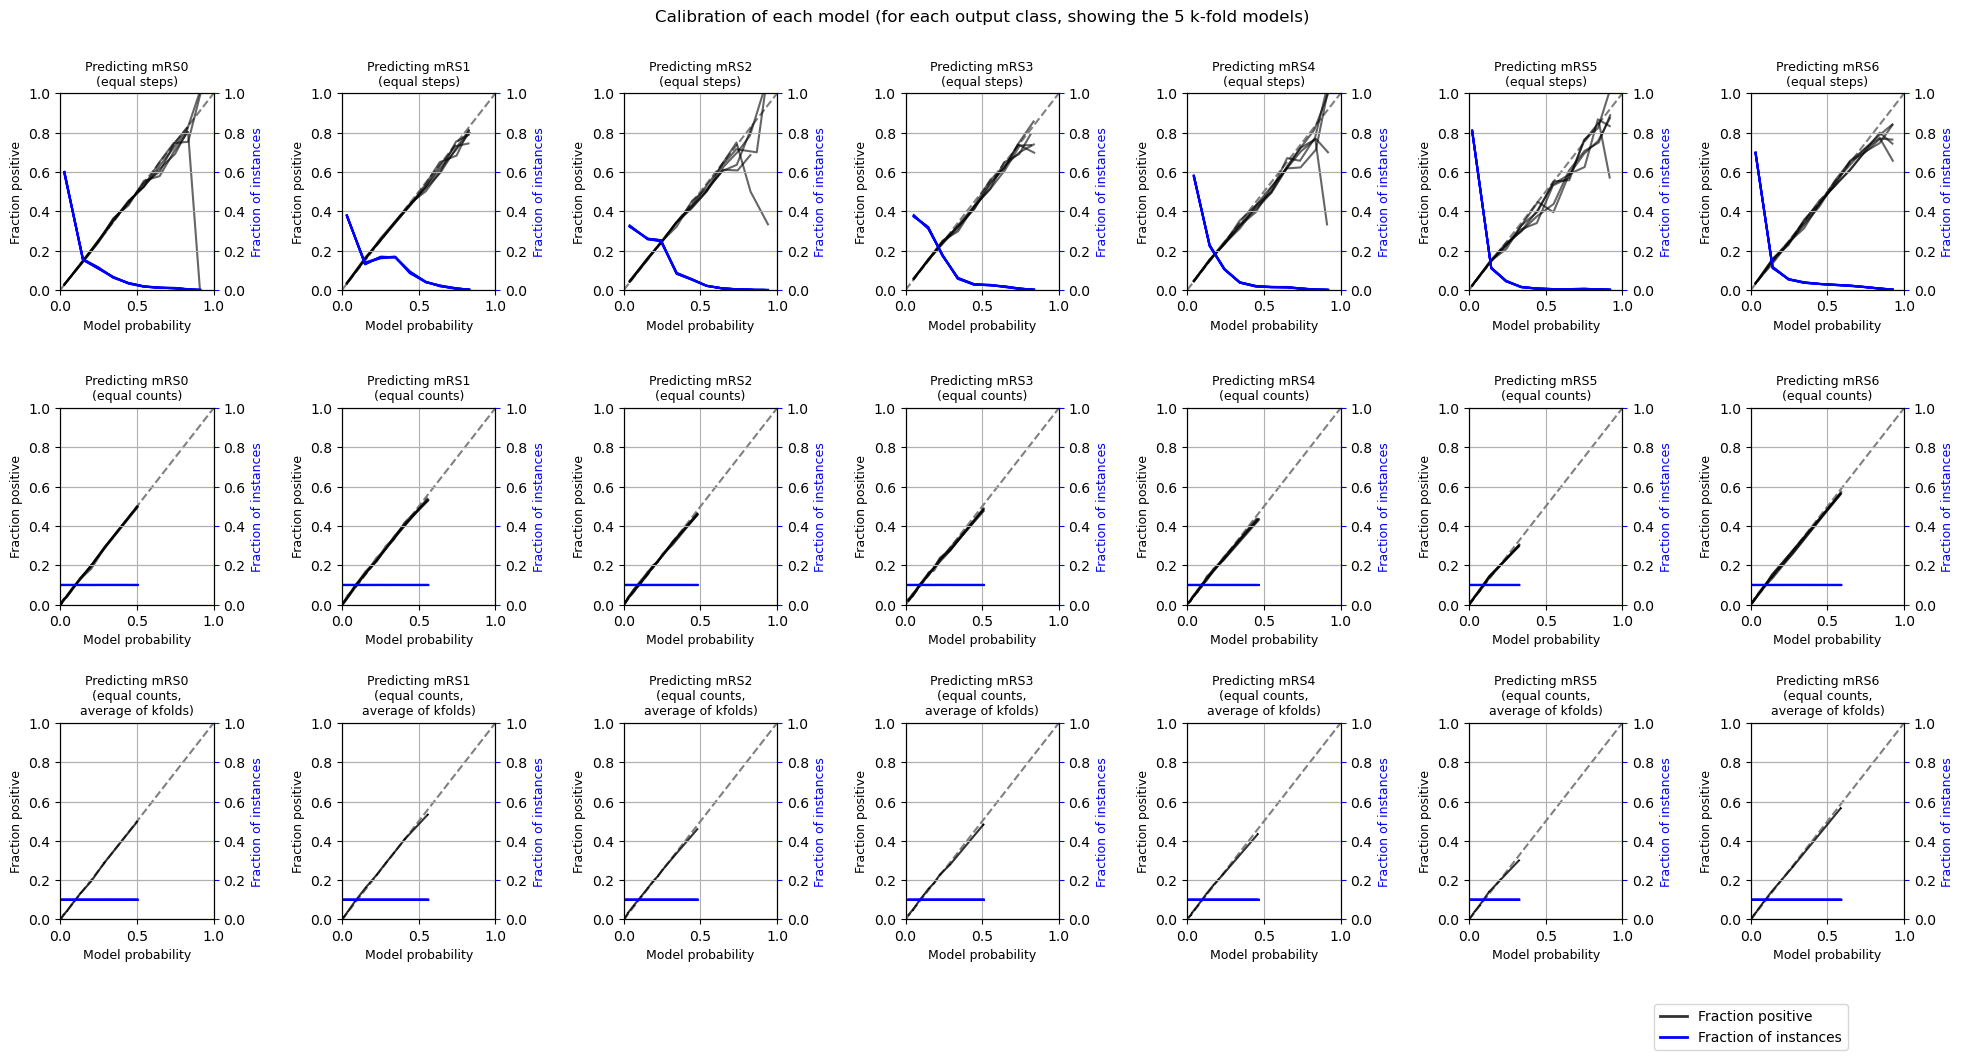

In [ ]:
# Setup dictionary to store dataframes of results
dict_results = dict()

fig = plt.figure(figsize=(20,10))

fig.suptitle("Calibration of the model "
             "(for each output class)")

bin_methods = ['steps', 'counts']
n_bin_methods = len(bin_methods)

subplot = 0

# A subplot
for bin_method in bin_methods:

    # Reset column counter
    col = 0

    # loop through the output classes
    for c in class_names:

        # Collate results for each class in a Dataframe (from the different 
        # kfolds)
        reliability_collated = pd.DataFrame()

        # Get observed class
        observed = y_test
        
        # And convert to binary for this class (1 = in class, 0 = rest)
        observed_binary = observed == c

        # Probability for current class and kfold, for all instances
        prob_observed = y_probs[:,col]

        # Determine the models classification of each instance
        classification = np.argmax(y_probs, axis=1)

        # Depending on bin method, convert prob_observed into bins            
        (bins, digitized) = calculate_bins_digitized(bin_method, 
                                                        prob_observed)

        # Put single fold data in DataFrame
        df_reliability = create_df_reliability(digitized, prob_observed,
                            observed_binary, classification, observed, c)

        # Summarise data by bin in new dataframe
        df_reliability_by_bins = group_data_by_bins(bins,k,df_reliability)

        # Add k-fold results to DataFrame collation
        reliability_collated = reliability_collated.append(
                                                    df_reliability_by_bins)

        # Get probability from next column (for next class)
        col += 1
        subplot += 1

        # Get mean results across kfolds
        reliability_mean_kfolds = reliability_collated.groupby('bin').mean()
        reliability_mean_kfolds.drop('k-fold', axis=1, inplace=True)
    
        # Plot predicted prob vs fraction positive
        ax = fig.add_subplot(n_bin_methods, n_classes, subplot)

        plot_fraction_positive(reliability_collated, c, ax, k, 
                                title_text=f"(equal {bin_method})")

        # instantiate a second axes that shares the same x-axis
        ax1 = ax.twinx()  

        plot_fraction_instances(reliability_collated, ax1, k)

        ax.grid()
        ax1.grid()

        plt.tight_layout(pad=2)

        # Store in dictionary
        dict_results[f'reliability_collated_{bin_method}_{c}'] = (
                                                        reliability_collated)
        dict_results[f'reliability_mean_kfolds_{bin_method}_{c}'] = (
                                                        reliability_mean_kfolds)
        
# Only put one legend in figure (bottom left subplot)
custom_lines = [Line2D([0], [0], color='k', alpha=0.8, lw=2),
                Line2D([0], [0], color='blue', lw=2)]

# Place it below x axis a quarter length of y axis
y_range = ax.get_ylim()[1] - ax.get_ylim()[0]

plt.legend(custom_lines, 
            ['Fraction positive', 'Fraction of instances'],
            loc='lower center', 
            bbox_to_anchor=(0,-(y_range * 0.7), 0, 0))


filename = os.path.join(paths.image_save_path, 
                       (paths.notebook + paths.model_text + '_calibration.jpg'))
plt.savefig(filename, dpi=300)

## Section 3: Reliability

What's the accuracy of model, when model is at least a certain threshold confident?

As the model output is softmax (meaning that the sum of all of the class outputs add up to one), if an instance is 50% certain, then it will be classified as this (as no other class could exceed this). Not expecting many to be, as the model splits it's certainty across 7 classes (so an ewqual weighting would be 14%, 1/7).

For example, look at the model predicting if an instance is each class: How many instances is the model 50% certain that the instance is that class?

Choosing any threshold to see the performance of the model at this level of confidence.

In [ ]:
threshold = 0.5
col = 0

# Initialise lists. 
# For each class, store fraction of instances that the model is this certain
list_frac_certain_per_class = []
# For each class, store model accuracy for these instances
list_accuracy_of_these_per_class = []

for c in class_names:
    # Collate results for each class in a Dataframe
    reliability_collated = pd.DataFrame()

    # Get observed class
    observed = y_test
    # And convert to binary for this class (1 = in class, 0 = rest)
    observed_binary = observed == c

    # Probability for current class and kfold, for all instances
    prob_observed = y_probs[:,col]
    # Determine the models classification of each instance
    classification = np.argmax(y_probs, axis=1)
    
    # Put instances in bin (either less than, or greater than threshold)
    bins = [threshold, 1.0]
    digitized = np.digitize(prob_observed, bins)

    # Put this single kfold data in DataFrame, row per instance
    df_reliability = create_df_reliability(digitized, prob_observed,
                            observed_binary, classification, observed, c)

    # Group instances by bins
    df_reliability_by_bins = group_data_by_bins(bins, k, df_reliability)

    # Add k-fold results to DataFrame collation
    reliability_collated = reliability_collated.append(
                                                df_reliability_by_bins)
    # Get mean results for each bin across kfolds
    reliability_mean_kfolds = reliability_collated.groupby('bin').mean()

    # bin_for_threshold
    bin_for_threshold = 1.0
    frac = reliability_mean_kfolds.loc[bin_for_threshold]['fraction_results']
    acc = reliability_mean_kfolds.loc[bin_for_threshold]['fraction_correct']

    list_frac_certain_per_class.append(frac)
    list_accuracy_of_these_per_class.append(acc)
    
    col += 1

In [ ]:
def create_lists(threshold, n_kfold, class_names, train, y_test):
    """
    """
    col = 0

    # Initialise lists. 
    # For each class, store fraction of instances that the model is this certain
    list_frac_certain_per_class = []
    # For each class, store model accuracy for these instances
    list_accuracy_of_these_per_class = []

    for c in class_names:
        # Collate results for each class in a Dataframe
        reliability_collated = pd.DataFrame()

        # Get observed class
        observed = y_test
        # And convert to binary for this class (1 = in class, 0 = rest)
        observed_binary = observed == c

        # Probability for current class and kfold, for all instances
        prob_observed = y_probs[:,col]
        # Determine the models classification of each instance
        classification = np.argmax(y_probs, axis=1)
        
        # Put instances in bin (either less than, or greater than threshold)
        bins = [threshold, 1.0]
        digitized = np.digitize(prob_observed, bins)

        # Put this single kfold data in DataFrame, row per instance
        df_reliability = create_df_reliability(digitized, prob_observed,
                                observed_binary, classification, observed, c)

        # Group instances by bins
        df_reliability_by_bins = group_data_by_bins(bins, k, df_reliability)

        # Add k-fold results to DataFrame collation
        reliability_collated = reliability_collated.append(
                                                        df_reliability_by_bins)
        # Get mean results for each bin across kfolds
        reliability_mean_kfolds = reliability_collated.groupby('bin').mean()

        # bin_for_threshold
        bin_for_threshold = 1.0
        frac = reliability_mean_kfolds.loc[bin_for_threshold]['fraction_results']
        acc = reliability_mean_kfolds.loc[bin_for_threshold]['fraction_correct']

        list_frac_certain_per_class.append(frac)
        list_accuracy_of_these_per_class.append(acc)
        
        col += 1
    return(list_accuracy_of_these_per_class, list_frac_certain_per_class)

Average across the kfolds, plotting for each class the proportion of instances that the model is that confident about, and for those how many the model is correct on.

In [ ]:
def plot_reliability_chart(threshold, class_names, 
                           list_accuracy_of_these_per_class, 
                           list_frac_certain_per_class, ax):
    """
    
    """
    plt.title(f'Instances with at least {int(threshold * 100)}% '
            f'confidence from model')
        
    ax.plot(class_names, list_accuracy_of_these_per_class, color='darkorange', 
            linewidth=3)
    # Refine plot
    ax.set_xlabel('Discharge disability (mRS)')
    ax.set_ylabel(f'Accuracy for instances with > {int(threshold * 100)}% '
                f'confidence', color='xkcd:pumpkin', fontsize=8)
    ax.set_ylim((0,1))
    # instantiate a second axes that shares the same x-axis
    ax1 = ax.twinx()  
    ax1.plot(class_names, list_frac_certain_per_class, color='blue', 
             linewidth=3)
    ax1.set_ylabel(f'Proportion of instances with > {int(threshold * 100)}% '
                f'confidence', color='blue', fontsize=8)
    ax1.set_ylim((0,1))
            

    custom_lines = [Line2D([0], [0], color='darkorange', alpha=0.6, lw=2),
                    Line2D([0], [0], color='blue', alpha = 0.6,lw=2)]

    ax.grid()
    ax1.grid()

    plt.tight_layout()

    return()

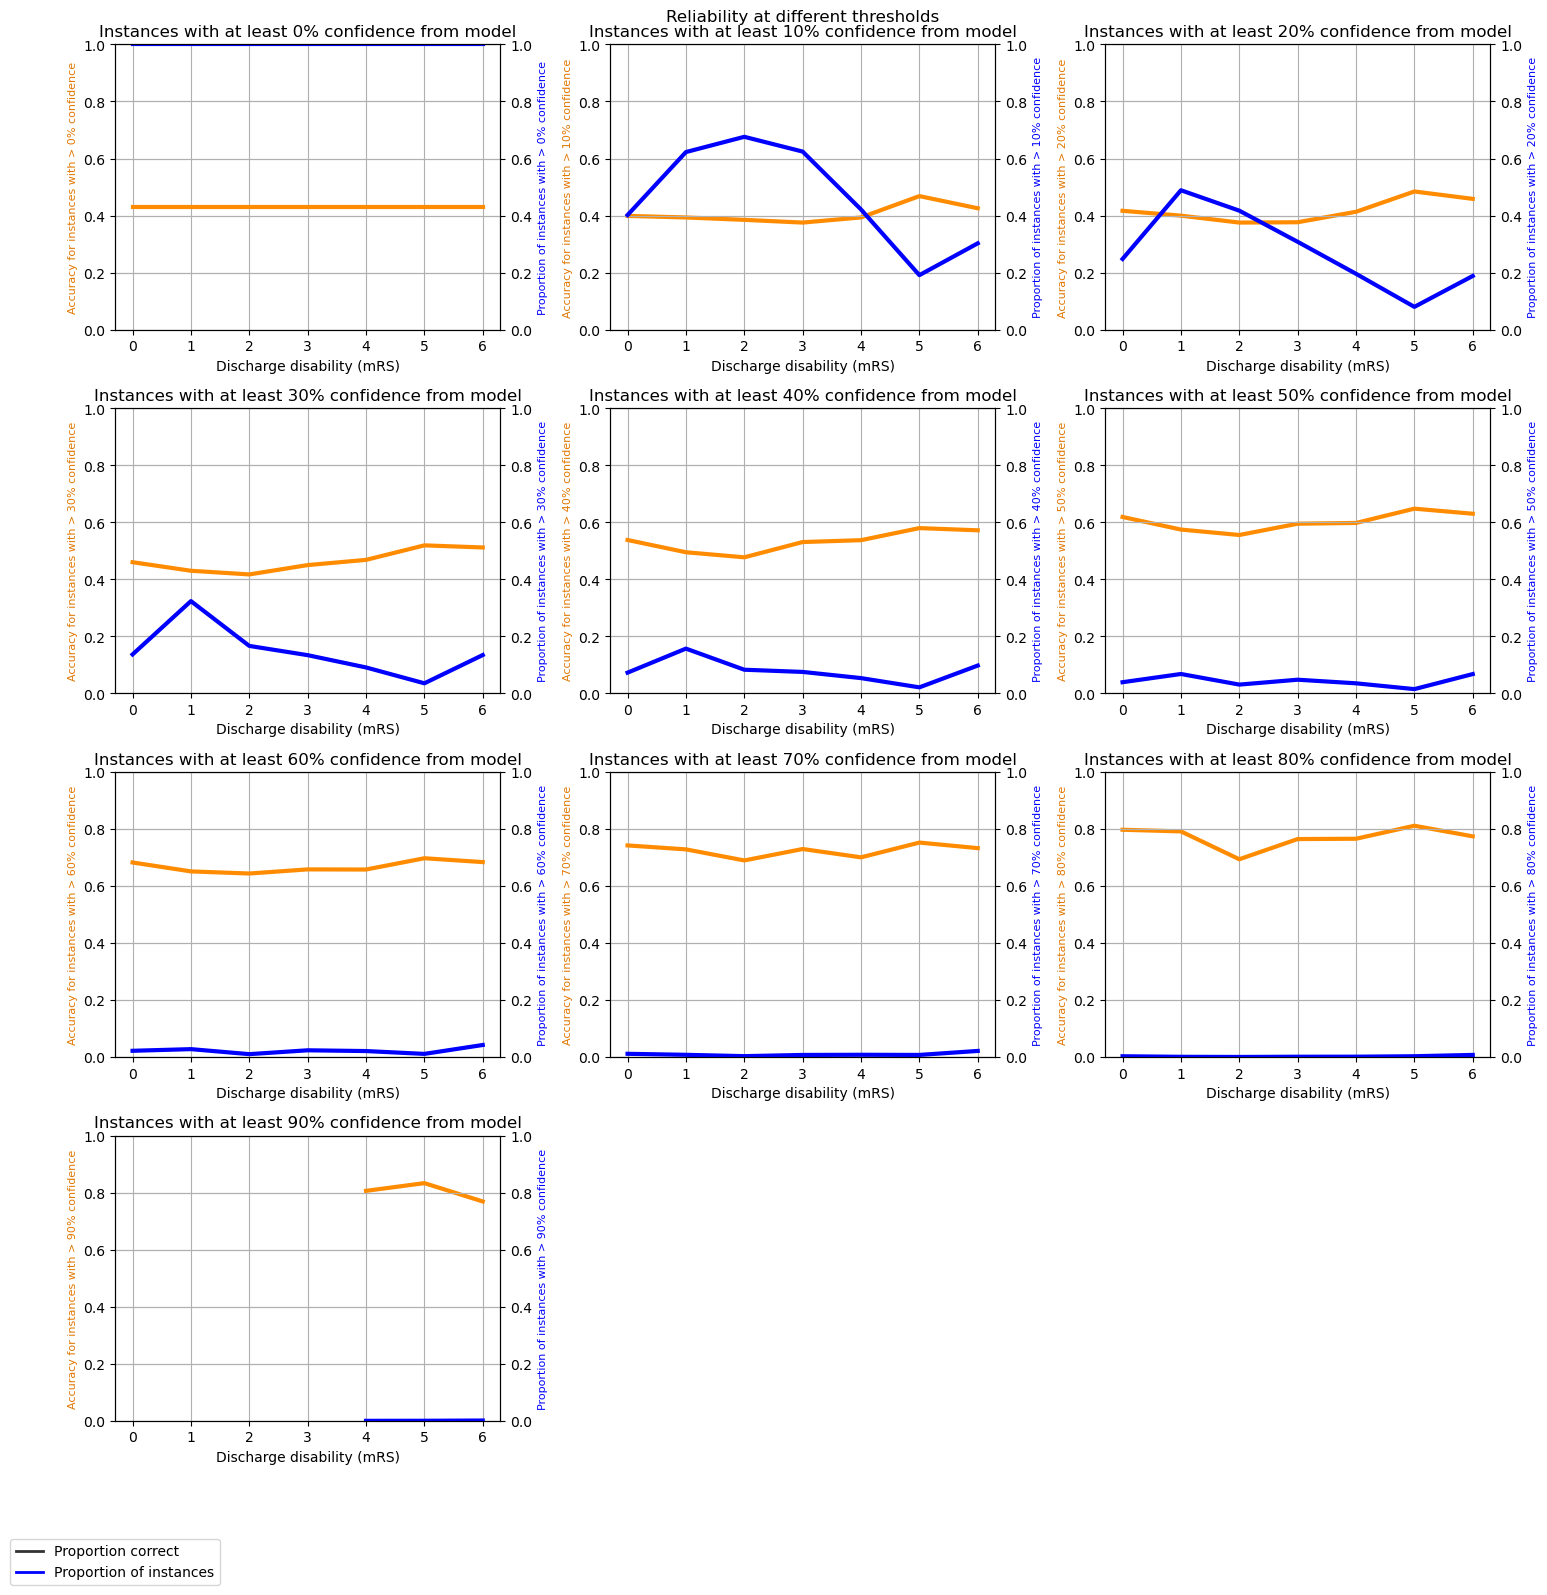

In [ ]:
fig = plt.figure(figsize=(15,15))

fig.suptitle("Reliability at different thresholds")

thresholds = list(range(0,10,1))
thresholds = [x/10 for x in thresholds]

n_cols = 3
n_rows = int((len(thresholds)/n_cols) + 0.99)

for i, threshold in enumerate(thresholds):
    # Plot accuracy vs probability
    ax = fig.add_subplot(n_rows,n_cols,i+1)

    (list_accuracy_of_these_per_class, list_frac_certain_per_class) = (
                create_lists(threshold, k, class_names, 
                        train, y_test))
    
    plot_reliability_chart(threshold, class_names, 
                           list_accuracy_of_these_per_class, 
                           list_frac_certain_per_class, ax)

# Make space for title
#plt.subplots_adjust(top=0.5)

plt.legend(custom_lines, ['Proportion correct', 'Proportion of instances'],
            loc='lower center', 
            bbox_to_anchor=(0,-(y_range * 0.6), 0, 0))
plt.show()